Initializing eigensolver data
Computing 5 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 100 x 100 x 1.
Solving for 5 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (2, 0, 0)
     (0, 2, 0)
     (0, 0, 1)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (0.5, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.4,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.25,0,0)
          size (0.4,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 3.0>
elapsed time for initialization: 0.014626264572143555
solve_kpoint (0,0,3):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5
Solving for band

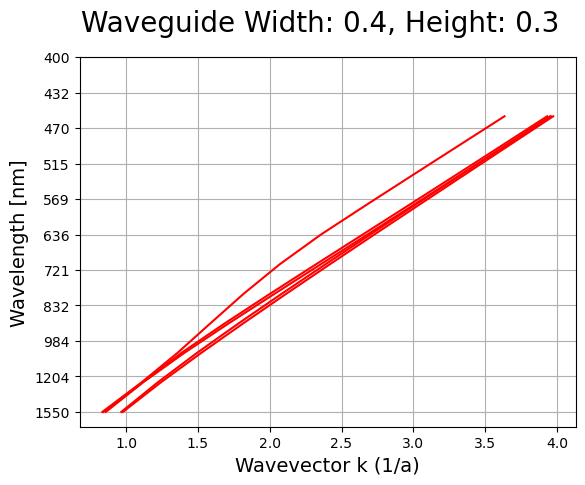

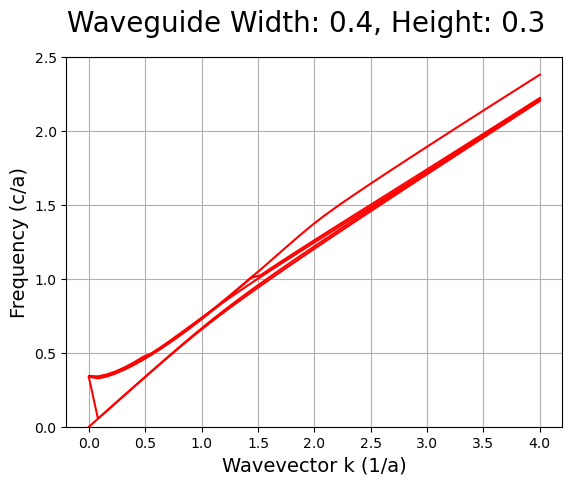

epsilon: 2.1025-3.81273, mean 2.20511, harm. mean 2.16065, 100% > 1, 6% "fill"
real part range: 2.1025 .. 3.81273
Initializing eigensolver data
Computing 5 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 100 x 100 x 1.
Solving for 5 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (2, 0, 0)
     (0, 2, 0)
     (0, 0, 1)
Cell volume = 4
Reciprocal lattice vectors (/ 2 pi):
     (0.5, -0, 0)
     (-0, 0.5, -0)
     (0, -0, 1)
Geometric objects:
     block, center = (-0.25,0,0)
          size (0.4,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0.25,0,0)
          size (0.4,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: te.
Initializing fields to random numbers...
51 k-points
  Vector3<0.0, 0.0, 0.0>
  Vector3<0.0, 0.0, 0.08>
  Vector3<0.0, 0.0, 0.16>
  Vector3<0.0, 0.0, 0.

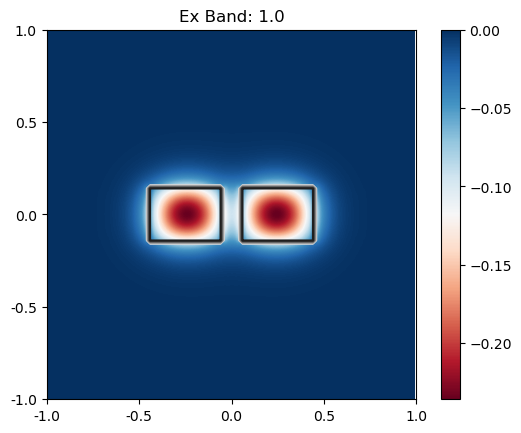

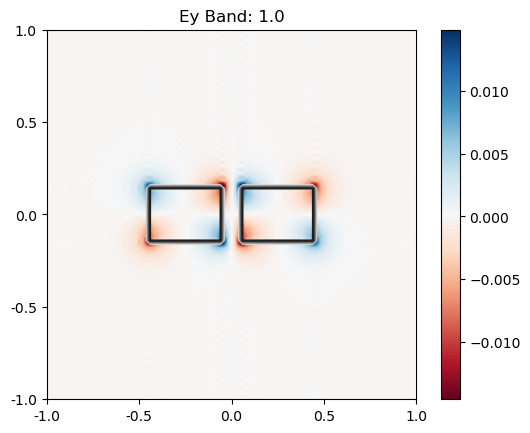

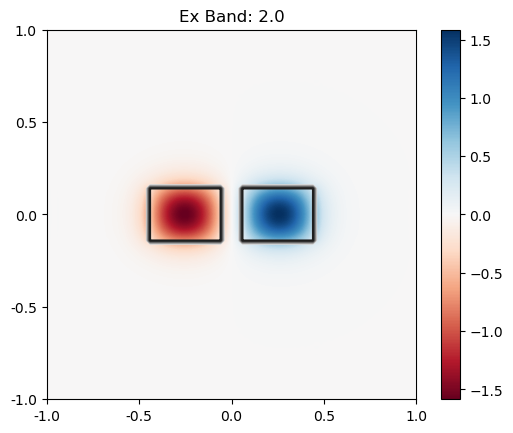

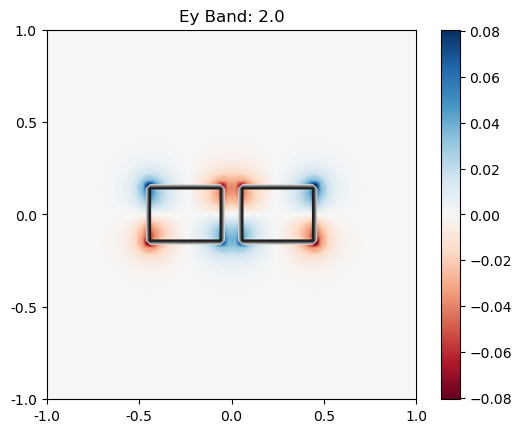

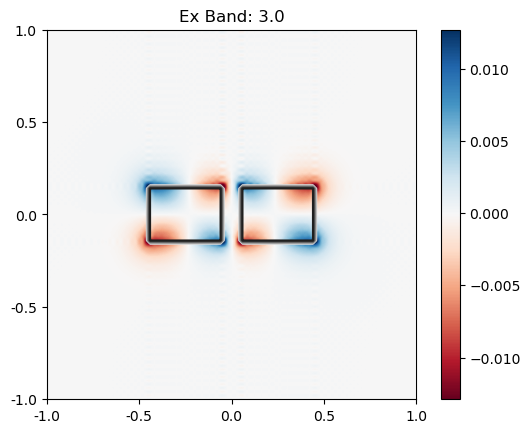

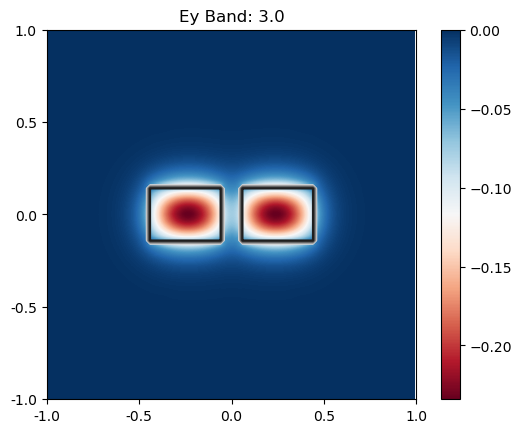

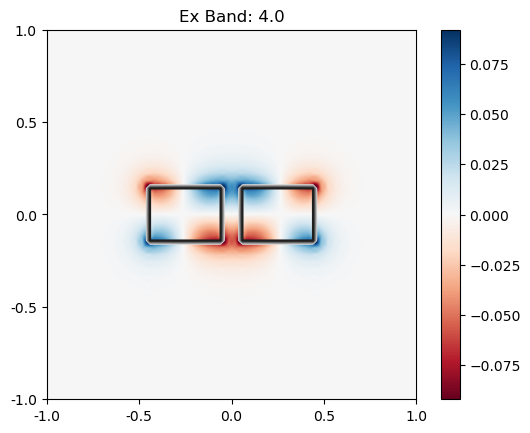

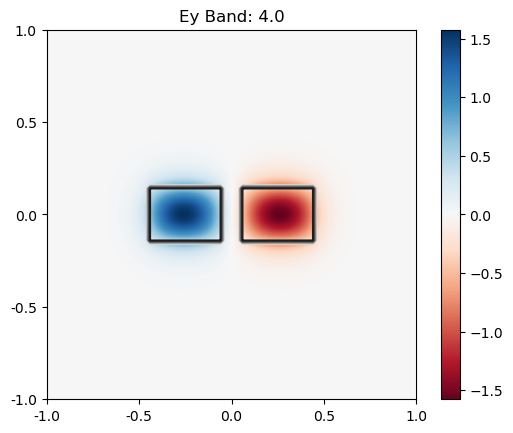

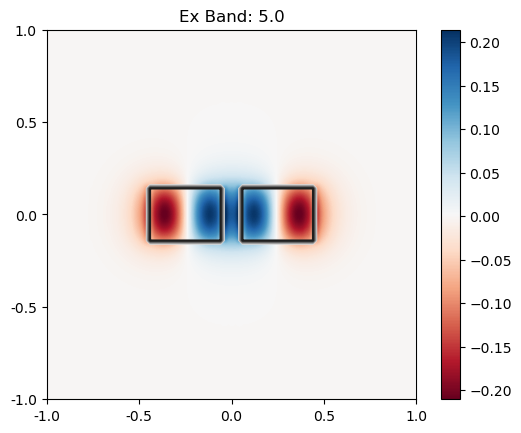

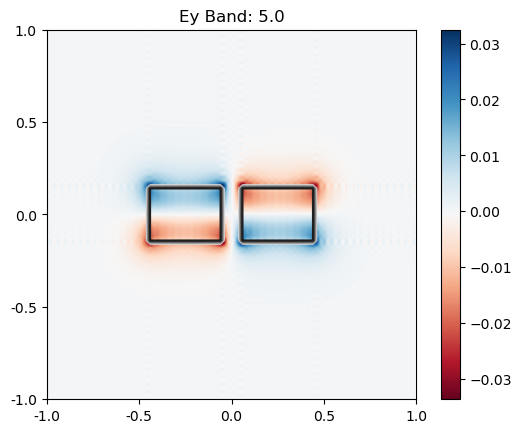

In [4]:
import meep as mp
from meep import mpb
import numpy as np
import matplotlib.pyplot as plt


def processMaterial(material, wavelength, mult=1):
	if material is not None:
		if isinstance(material, type(lambda:0)):
			n = material(wavelength)
			eps = np.real(n*n)
			return mp.Medium(epsilon_diag=mp.Vector3(mult*eps, mult*eps, mult*eps), valid_freq_range=mp.FreqRange(min=0, max=1e12))
		elif material is mp.air:
			return material
		elif material.valid_freq_range is None:
			v = material.epsilon_diag
			return mp.Medium(epsilon_diag=mp.Vector3(np.real(v[0]), np.real(v[1]), np.real(v[2])), valid_freq_range=mp.FreqRange(min=0, max=1e12))
		else:
			eps = np.real(material.epsilon(1/wavelength))
			return mp.Medium(epsilon_diag=mp.Vector3(mult*eps[0, 0], mult*eps[1, 1], mult*eps[2, 2]), valid_freq_range=material.valid_freq_range)
	else:
		return None

# Constants and Simulation Parameters
um_scale = 1  # Scale for micrometers
resolution = 50  # Resolution of the simulation
num_bands = 5  # Number of bands to calculate
num_kpoints = 50  # Number of k-points for interpolation
lattice_x = 2  # Lattice size in x-direction
lattice_y = 2  # Lattice size in y-direction
wgW = 0.4  # Waveguide width
wgH = 0.3  # Waveguide height
wl = 0.515  # Wavelength
k_max = 4  # Maximum wavevector
ticknum = 10  # Number of ticks for plotting
sep = 0.5 # Waveguide separation
# Material definitions using Meep's material library and custom functions
mitreSiN = mp.Medium(epsilon=1, E_susceptibilities=[mp.LorentzianSusceptibility(frequency=1/0.1295/um_scale, gamma=0, sigma=2.6817)])
mitreSiN = processMaterial(mitreSiN, 0.6)  # Custom processing of material properties
clad_material = processMaterial(mp.Medium(index=1.45), wl)  # Cladding material
wg_material = processMaterial(mitreSiN, wl)  # Waveguide material

# Lattice and geometry setup for the simulation
lattice = mp.Lattice(size=mp.Vector3(lattice_x, lattice_y, 0))  # Defining the lattice
k_points = mp.interpolate(num_kpoints - 1, [mp.Vector3(), mp.Vector3(0, 0, k_max)])  # Interpolating k-points

wg_geom1=mp.Block(center=mp.Vector3(-sep/2,0,0),size=mp.Vector3(wgW, wgH, mp.inf), material=wg_material)
wg_geom2=mp.Block(center=mp.Vector3(sep/2,0,0),size=mp.Vector3(wgW, wgH, mp.inf), material=wg_material)

geometry = [wg_geom1, wg_geom2]  # Defining the geometry
kz_components = [k.z for k in k_points]
# Frequency range for band structure calculation
omega_min = 1/1.55
omega_max = 1/0.40
omega_points = 12
OmegaRange = np.arange(omega_min, omega_max, (omega_max - omega_min) / omega_points)
k = []  # List to store wavevectors
Omegas = []  # List to store frequencies

# Mode solver setup
ms = mpb.ModeSolver(num_bands=num_bands,
                    default_material=clad_material,
                    geometry_lattice=lattice,
                    k_points=k_points,
                    geometry=geometry,
                    resolution=resolution)

# Running the solver for each frequency in the range
for omega in OmegaRange:
    try:
        # Finding the wavevector (k) for each frequency
        k.append(ms.find_k(tol=0.01, p=mp.NO_PARITY, omega=omega, band_min=1, band_max=num_bands, kmag_min=0, kmag_max=k_max, kmag_guess=3, korig_and_kdir=mp.Vector3(0, 0, 3)))
        Omegas.append(omega)
    except:
        # Break the loop if an error occurs
        break

# Re-setup the mode solver for Transverse Electric (TE) mode calculation
ms = mpb.ModeSolver(num_bands=num_bands,
                    default_material=clad_material,
                    geometry_lattice=lattice,
                    k_points=k_points,
                    geometry=geometry,
                    resolution=resolution)

# Run the mode solver for TE modes
ms.run_te()
te_freqs = ms.all_freqs  # Fetching the frequencies of TE modes

# Plotting the band structure as wavelength vs. wavevector
fig, ax = plt.subplots()
ax.plot(k, Omegas, color='red')
tick_locs = [(omega_min+(omega_max-omega_min)/ticknum*i) for i in range(ticknum+1)]

tick_labs = [round(1000*1/(omega_min+(omega_max-omega_min)/ticknum*i)) for i in range(ticknum+1)]
ax.set_yticks(tick_locs)
ax.set_yticklabels(tick_labs)


ax.set_ylabel('wavelength [nm]', size=14)
ax.set_xlabel('k (1/a)', size=14)

fig.suptitle("Waveguide Width: " + str(wgW) + ", Height: " + str(wgH), fontsize=20)
ax.set_ylabel('Wavelength [nm]', size=14)
ax.set_xlabel('Wavevector k (1/a)', size=14)
ax.grid(True)
plt.show()

# Plotting frequency vs. wavevector for TE modes
fig, ax = plt.subplots()
ax.plot(kz_components, te_freqs, color='red')
ax.set_ylim([0, omega_max])
fig.suptitle("Waveguide Width: " + str(wgW) + ", Height: " + str(wgH), fontsize=20)
ax.set_ylabel('Frequency (c/a)', size=14)
ax.set_xlabel('Wavevector k (1/a)', size=14)
ax.grid(True)
plt.show()

# Epsilon and electric field calculation and plotting
md = mpb.MPBData(rectify=True, periods=1, resolution=resolution)
eps = ms.get_epsilon()  # Get epsilon (dielectric constant) distribution
converted_eps = md.convert(eps)  # Convert epsilon data for plotting

efields = []  # List to store electric fields

def get_efields(ms, band):
    # Function to fetch and store electric fields for each band
    efields.append(ms.get_efield(band, bloch_phase=True))

# Run the mode solver for TE modes and get electric fields at a specific k-point
ms.run_te(mpb.output_at_kpoint(mp.Vector3(0, 0, 1/wl), mpb.fix_efield_phase, get_efields))

# Transforming electric fields for plotting
md = mpb.MPBData(rectify=True, resolution=resolution, periods=1)
converted = []  # List to store converted electric fields

for ii in range(num_bands):
    f = ms.get_efield(ii + 1, bloch_phase=True)
    converted.append(md.convert(f[..., 0, 0]))  # Horizontal polarization
    converted.append(md.convert(f[..., 0, 1]))  # Vertical polarization

counter = 0  # Counter for plotting titles
# Plotting electric field distributions for each band and polarization
for i, f in enumerate(converted):
    counter += 1
    fig, ax = plt.subplots()  # Create a new figure and axes

    # Plot the dielectric constant distribution as contours
    plt.contour(converted_eps.T, cmap='binary')
    
    # Plot the electric field distribution
    plt.imshow(np.real(f).T, interpolation='spline36', cmap='RdBu', alpha=1)

    # Determine the title based on the polarization
    title = "Ex" if np.mod(counter, 2) == 1 else "Ey"

    # Set colorbar
    plt.colorbar()    

    # Set title
    plt.title(title + " Band: " + str(np.ceil(counter / 2)))

    # Set x and y limits to center the waveguide
    ax.set_xlim(0, resolution * lattice_x)
    ax.set_ylim(0, resolution * lattice_y)

    # Adjust the axes' ticks to match the lattice dimensions
    ax.set_xticks(np.linspace(0, resolution * lattice_x, 5))
    ax.set_xticklabels(np.linspace(-lattice_x/2, lattice_x/2, 5))

    ax.set_yticks(np.linspace(0, resolution * lattice_y, 5))
    ax.set_yticklabels(np.linspace(-lattice_y/2, lattice_y/2, 5))

    # Show the plot
    plt.show()